<a href="https://colab.research.google.com/github/LucianStefanAndrei/CNNs/blob/main/brain_mri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import random
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL
import zipfile
import matplotlib as plt
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import cv2
import matplotlib.pyplot as plt



In [2]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 195MB/s]


In [3]:
def extract_zip(zip_path, extract_to):
    # Check if the ZIP file exists
    if not os.path.exists(zip_path):
        print(f"ZIP file {zip_path} does not exist.")
        return

    # Create the destination directory if it does not exist
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    # Open the ZIP file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Extract all the contents of the ZIP file to the specified directory
        zip_ref.extractall(extract_to)
        print(f"Extracted all files to {extract_to}")

# Path to the ZIP file
zip_file_path = '/content/brain-mri-images-for-brain-tumor-detection.zip'
# Directory where the contents should be extracted
extract_directory = 'brain_data'

# Extract the ZIP file
extract_zip(zip_file_path, extract_directory)

Extracted all files to brain_data


In [4]:
!apt-get install tree
#clear_output()
# create new folders
!mkdir train test val train/yes train/no test/yes test/no val/yes val/no
!tree -d

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (84.5 kB/s)
Selecting previously unselected package tree.
(Reading database ... 123576 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
.
├── brain_data
│   ├── brain_tumor_dataset
│   │   ├── no
│   │   └── yes
│   ├── no
│   └── yes
├── sample_data
├── test
│   ├── no
│   └── yes
├── train
│   ├── no
│   └── yes
└── val
    ├── no
    └── yes

16 directories


In [ ]:
def equalize_histogram(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    channels = cv2.split(image)
    cv2.equalizeHist(channels[0], channels[0])
    cv2.merge(channels, image)
    image = cv2.cvtColor(image, cv2.COLOR_YCrCb2BGR)
    return image


In [5]:
IMG_PATH = 'brain_data/brain_tumor_dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'test/' + CLASS + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'train/'+ CLASS + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'val/'+ CLASS + '/' + FILE_NAME)

In [47]:
def clahe_equalization(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)  # Convert to YCrCb color space
    channels = list(cv2.split(image)) # Split the image into channels and convert to a list
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    channels[0] = clahe.apply(channels[0])
    image = cv2.merge(channels)
    image = cv2.cvtColor(image, cv2.COLOR_YCrCb2RGB)  # Convert back to RGB color space
    return image

def custom_preprocessing(image):
    image = np.array(image, dtype=np.uint8)  # Convert to uint8 for OpenCV compatibility
    image = clahe_equalization(image)
    return image

datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5]
                        )

train_dir = 'train/'
val_dir = 'val/'


train_data = datagen.flow_from_directory(train_dir,
                                        target_size=(224,224),
                                         batch_size=16,
                                        class_mode="binary")

validation_data = datagen.flow_from_directory(val_dir,
                                       target_size=(224,224),
                                        batch_size=16,
                                       class_mode="binary")

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


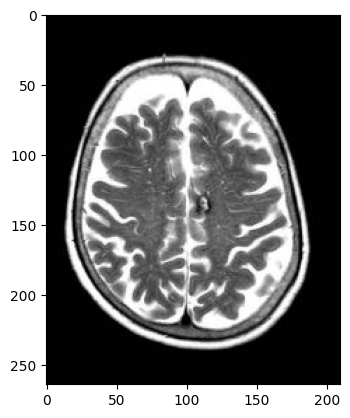

In [48]:
test_img = PIL.Image.open('/content/test/no/N26.JPG')
plt.imshow(test_img)


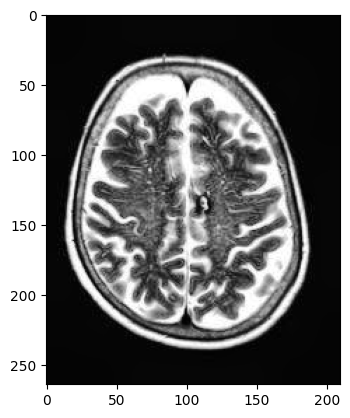

In [49]:
clahe_img = custom_preprocessing(np.array(test_img))
plt.imshow(clahe_img)

In [50]:
from collections import Counter

train_data_values = Counter(train_data.classes).values()
validation_data_values = Counter(validation_data.classes).values()

print("Train Data Values No/Yes:",train_data_values)
print("Valid Data Values No/Yes:",validation_data_values)

Train Data Values No/Yes: dict_values([74, 119])
Valid Data Values No/Yes: dict_values([19, 31])


In [51]:
def compute_class_weights(y):
    class_weights = {}
    classes, counts = np.unique(y, return_counts=True)
    total_counts = sum(counts)

    for cls, count in zip(classes, counts):
        class_weights[cls] = total_counts / (len(classes) * count)

    return class_weights
class_weights = compute_class_weights(train_data.classes)
print(class_weights)

{0: 1.304054054054054, 1: 0.8109243697478992}


In [52]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1,
    mode='min'
)


In [53]:
from tensorflow.keras import layers
EFFICIENT = tf.keras.applications.EfficientNetB1(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
)
for layer in EFFICIENT.layers[-4:]:  # Unfreeze the last few layers
    layer.trainable = True

In [54]:

efficient_model = tf.keras.Sequential()
efficient_model.add(EFFICIENT)
efficient_model.add(layers.Dropout(0.3))
efficient_model.add(layers.Flatten())
efficient_model.add(layers.Dense(1,activation="sigmoid"))

efficient_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])

efficient_history = efficient_model.fit(train_data,epochs=20,
                                        validation_data=validation_data,
                                        callbacks=[early_stopping,
                                      reduce_lr,
                                        model_checkpoint],
                                        class_weight=class_weights)

Epoch 1/20
13/13 [==============================] - ETA: 0s - loss: 1.5875 - accuracy: 0.6373
Epoch 1: val_loss improved from inf to 0.93574, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 114s 543ms/step - loss: 1.5875 - accuracy: 0.6373 - val_loss: 0.9357 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 2/20
13/13 [==============================] - ETA: 0s - loss: 1.0559 - accuracy: 0.8238
Epoch 2: val_loss did not improve from 0.93574
13/13 [==============================] - 6s 438ms/step - loss: 1.0559 - accuracy: 0.8238 - val_loss: 1.4025 - val_accuracy: 0.4400 - lr: 0.0010
Epoch 3/20
13/13 [==============================] - ETA: 0s - loss: 0.4404 - accuracy: 0.8497
Epoch 3: val_loss improved from 0.93574 to 0.65082, saving model to best_model.h5
13/13 [==============================] - 5s 417ms/step - loss: 0.4404 - accuracy: 0.8497 - val_loss: 0.6508 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 4/20
13/13 [==============================] - ETA: 0s - loss: 0.2581 - accuracy: 0.9067
Epoch 4: val_loss did not improve from 0.65082
13/13 [==============================] - 5s 385ms/step - loss: 0.2581 - accuracy: 0.9067 - val_loss: 0.7637 

In [56]:


MOBILENET = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
)
for layer in EFFICIENT.layers[-5:]:  # Unfreeze the last few layers
    layer.trainable = True




mobilenet_model = tf.keras.Sequential()
mobilenet_model.add(EFFICIENT)
mobilenet_model.add(layers.Dropout(0.3))
mobilenet_model.add(layers.Flatten())
mobilenet_model.add(layers.Dense(1,activation="sigmoid"))

mobilenet_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])

mobilenet_history = mobilenet_model.fit(train_data,
                                        epochs=30,
                                        validation_data=validation_data,
                                        callbacks=[early_stopping, reduce_lr, model_checkpoint],
                                        class_weight=class_weights)

Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.7012 - accuracy: 0.7979
Epoch 1: val_loss did not improve from 0.16108
13/13 [==============================] - 54s 483ms/step - loss: 0.7012 - accuracy: 0.7979 - val_loss: 0.2173 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.6899 - accuracy: 0.9067
Epoch 2: val_loss did not improve from 0.16108
13/13 [==============================] - 5s 332ms/step - loss: 0.6899 - accuracy: 0.9067 - val_loss: 2.4639 - val_accuracy: 0.6800 - lr: 0.0010
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.6727 - accuracy: 0.8705
Epoch 3: val_loss did not improve from 0.16108
13/13 [==============================] - 4s 334ms/step - loss: 0.6727 - accuracy: 0.8705 - val_loss: 1.7145 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.5113 - accuracy: 0.8601
Epoch 4: val_loss did not improve from 0.16108
13/

<Axes: >

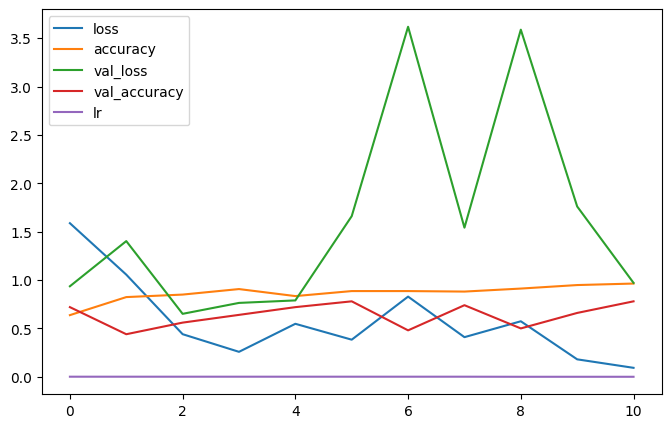

In [57]:
pd.DataFrame(efficient_history.history).plot(figsize=(8, 5))


<Axes: >

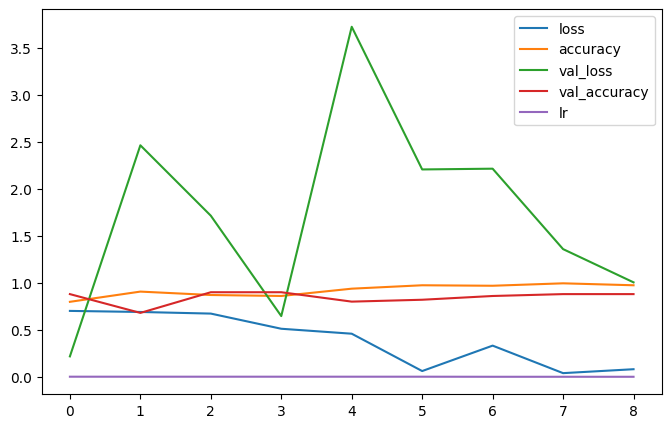

In [58]:
pd.DataFrame(mobilenet_history.history).plot(figsize=(8, 5))

In [59]:


def load_and_resize_images(directory, size=(224, 224)):
    image_list = []
    for filename in os.listdir(directory):
        if filename.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):
            img_path = os.path.join(directory, filename)
            with PIL.Image.open(img_path) as img:
                img = img.resize(size)
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                image_list.append(np.array(img))
    return np.array(image_list)

# Directory containing the images
no_directory = 'test/no'
yes_directory = 'test/yes'
# Load and resize images
no_images = load_and_resize_images(no_directory, size=(224, 224))
yes_images = load_and_resize_images(yes_directory, size=(224, 224))
print(no_images.shape)
print(yes_images.shape)


(5, 224, 224, 3)
(5, 224, 224, 3)


In [60]:
train_data.class_indices
no_results = mobilenet_model.predict(no_images)
yes_results = mobilenet_model.predict(yes_images)

no_final = np.squeeze(np.round(no_results))
yes_final = np.squeeze(np.round(yes_results))

print(f"No tumor Images:,  {no_final}")
print(f"Tumor Images:, {yes_final}")
print(train_data.class_indices)

1/1 [==============================] - 0s 31ms/step
No tumor Images:,  [0. 0. 0. 0. 0.]
Tumor Images:, [1. 1. 1. 1. 1.]
{'no': 0, 'yes': 1}


In [61]:
train_data.class_indices
no_results_efficient = efficient_model.predict(no_images)
yes_results_efficient = efficient_model.predict(yes_images)

no_final_efficient = np.squeeze(np.round(no_results_efficient))
yes_final_efficient = np.squeeze(np.round(yes_results_efficient))

print(f"No tumor Images:,  {no_final_efficient}")
print(f"Tumor Images:, {yes_final_efficient}")
print(train_data.class_indices)

1/1 [==============================] - 0s 30ms/step
No tumor Images:,  [0. 0. 0. 0. 0.]
Tumor Images:, [0. 1. 1. 1. 0.]
{'no': 0, 'yes': 1}


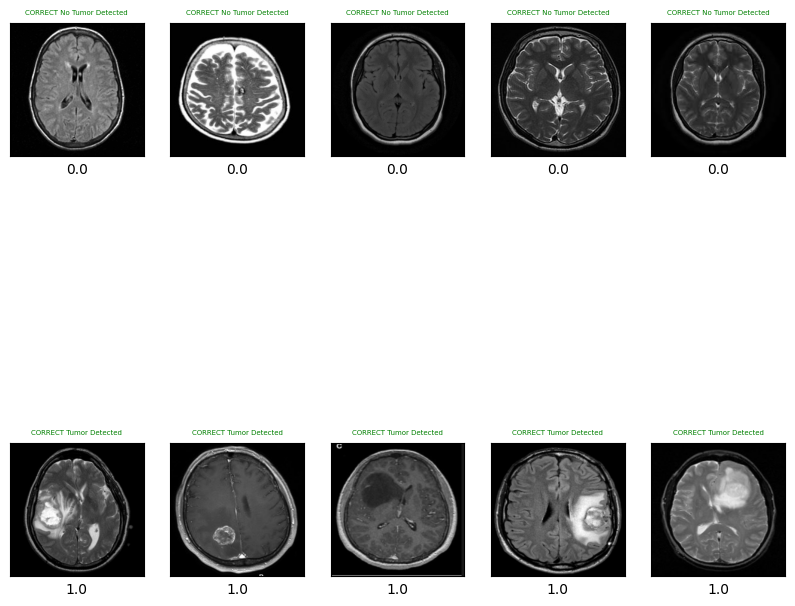

In [62]:
# prompt: plot 10 images, 2 labels total


def plot_images(images, labels, compare_labels,num_images=10):
  """
  Plots a specified number of images with their corresponding labels.

  Args:
    images: A 2D NumPy array containing the images.
    labels: A 1D NumPy array containing the labels for each image.
    num_images: The number of images to plot (default: 10).
  """

  FONTSIZE = 5
  plt.figure(figsize=(10, 10))
  for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap="gray")
    plt.xlabel(labels[i])
    if labels[i] == compare_labels[i]:
      if labels[i] == 0:
        plt.title("CORRECT No Tumor Detected", c="green",fontsize=FONTSIZE)
      else:
        plt.title("CORRECT Tumor Detected", c="green",fontsize=FONTSIZE)
    else:
      if labels[i] == 0:
        plt.title("INCORRECT No Tumor Detected", c="red",fontsize=FONTSIZE)
      else:
        plt.title("INCORRECT Tumor Detected", c="red",fontsize=FONTSIZE)
  plt.show()

# Plot the first 10 images from each category
no_images_subset = no_images
yes_images_subset = yes_images

no_labels = no_final
yes_labels = yes_final

plot_images(np.concatenate((no_images_subset, yes_images_subset)), np.concatenate((no_labels, yes_labels)),compare_labels=np.concatenate(([0.,0.,0.,0.,0.],[1.,1.,1.,1.,1.])))


In [63]:
feature_img = tf.expand_dims(yes_images[2],axis=0)
feature_img.shape

TensorShape([1, 224, 224, 3])

In [64]:
# Preia rezulatul primului layer de convolutie
model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
)
model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[1].output)


In [65]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
Total params: 864 (3.38 KB)
Trainable params: 864 (3.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [66]:
#Rezultatele primei convolutii pe imaginea selectata
features = model.predict(feature_img)

1/1 [==============================] - 0s 42ms/step


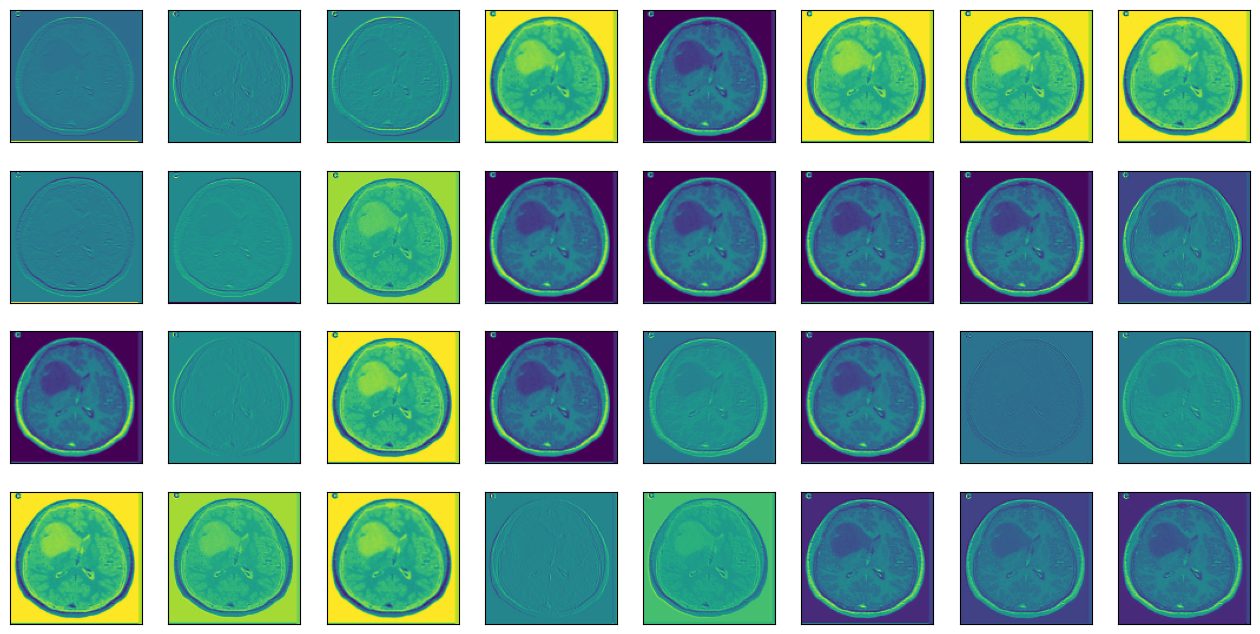

In [67]:
# Ce invata primul layer de convolutie din a 2-a imagine de tumoare
import matplotlib.pyplot as pyplot
ix = 1
plt.figure(figsize=(16,8))
for _ in range(4):
    for _ in range(8):
        # specify subplot and turn of axis
        ax = pyplot.subplot(4, 8, ix)
        ax.set_xticks([])
        ax.set_yticks([])

        # plot filter channel in grayscale
        if ix-1 < features.shape[3]: # Check if index is within bounds
            pyplot.imshow(features[0, :, :, ix-1], cmap='viridis')
        ix += 1

# show the figure
pyplot.show()

In [68]:
print("MOBILENET ARE O ACURATETE DE: ",mobilenet_history.history["accuracy"][-1])
print("EFFICIENT ARE O ACURATETE DE: ",efficient_history.history["accuracy"][-1])
print("MOBILENET ARE O ACURATETE LA VALIDARE DE: ",mobilenet_history.history["val_accuracy"][-1])
print("EFFICIENT ARE O ACURATETE LA VALIDARE DE: ",efficient_history.history["val_accuracy"][-1])

MOBILENET ARE O ACURATETE DE:  0.9740932583808899
EFFICIENT ARE O ACURATETE DE:  0.9637305736541748
MOBILENET ARE O ACURATETE LA VALIDARE DE:  0.8799999952316284
EFFICIENT ARE O ACURATETE LA VALIDARE DE:  0.7799999713897705
